In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

### Creating Splits

In [2]:
# Load in dataframes with patients that pass QC test and outcomes_df_df_df_df data

heal_qc = pd.read_csv('../data/HEAL QC - QC List.csv')
outcomes_df = pd.read_csv('../data/outcomes.csv')

# Get subjects that pass QC
pass_qc = heal_qc.loc[heal_qc['AI Include'], 'Study ID']

# Keep only subject with outcomes data; some patients were lost to followup in HEAL study
has_outcome = outcomes_df.loc[pd.isna(outcomes_df['primary_all']) == False, 'studyid']

# Get intersection of passing QC patients with outcomes
useable_pts = sorted(list(set(pass_qc) & set(has_outcome)))
useable_df = outcomes_df.loc[outcomes_df['studyid'].isin(useable_pts)]

# Finally verify that all the files we need are present
base_dir = Path('../ext_storage/mri_data/all/')

sequence_suffixes = ['T1_wm', 'T2_wm', 'DTI_eddy_MD_wm', 'DTI_eddy_trace_wm', 'DTI_eddy_FA_wm']
missing_subjects = []

# If any file is missing we cannot use the subject
for subject in useable_pts:
    for sequence in sequence_suffixes:
        if not os.path.isfile(base_dir / f'{subject}/{subject}_{sequence}.nii.gz'):
            print('Missing:', base_dir / f'{subject}/{subject}_{sequence}.nii.gz')

            missing_subjects.append(subject)

useable_df = useable_df.loc[~useable_df['studyid'].isin(missing_subjects)]
useable_pts = useable_df['studyid']

print(f'Total number of patients: {len(outcomes_df)}')
print(f'Number of patients with imaging that passes QC: {len(pass_qc)}')
print(f'Number of patients with outcome data: {len(has_outcome)}')
print(f'Number of patients with some missing data: {len(missing_subjects)}')
print()
print(f'Patients with images that pass QC and outcome data: {len(useable_df)}')


Missing: ../ext_storage/mri_data/all/CLA114/CLA114_DTI_eddy_trace_wm.nii.gz
Missing: ../ext_storage/mri_data/all/CLA122/CLA122_DTI_eddy_trace_wm.nii.gz
Total number of patients: 501
Number of patients with imaging that passes QC: 430
Number of patients with outcome data: 480
Number of patients with some missing data: 2

Patients with images that pass QC and outcome data: 412


In [3]:
# Get institution codes
useable_df.loc[:, 'institution_code'] = useable_df['studyid'].str[0:3]

institution_count = useable_df['institution_code'].nunique()

print(f'Number of institutions: {institution_count}')

# See numbers for each institution
display(useable_df['institution_code'].value_counts())

# Percent
display(useable_df['institution_code'].value_counts() / len(useable_df) * 100)

Number of institutions: 17


institution_code
NCH    47
CNM    39
STA    34
CHM    29
WUS    29
UOW    28
IND    25
UCF    25
CLA    24
DAL    22
FTW    22
CHP    20
STX    16
PIT    15
VCH    15
CCH    14
UOU     8
Name: count, dtype: int64

institution_code
NCH    11.407767
CNM     9.466019
STA     8.252427
CHM     7.038835
WUS     7.038835
UOW     6.796117
IND     6.067961
UCF     6.067961
CLA     5.825243
DAL     5.339806
FTW     5.339806
CHP     4.854369
STX     3.883495
PIT     3.640777
VCH     3.640777
CCH     3.398058
UOU     1.941748
Name: count, dtype: float64

In [4]:
# Goal is to have a test set of 20% of data, half from one institution and half otherwise randomly selected
# So we will use CNM institution
institution_test_set = useable_df.loc[useable_df['institution_code'] == 'CNM']
institution_test_set_pts = institution_test_set['studyid']

# Grab remaining 20% (11.6%) from the rest of the pts
exclude_institution = useable_df.loc[~(useable_df['institution_code'] == 'CNM')]

total_test_count = int(len(useable_df) * 0.20)
remaining_test_count = total_test_count - len(institution_test_set)

internal_test_set = exclude_institution.sample(n=remaining_test_count)
internal_test_set_pts = internal_test_set['studyid']

print(f'External test set count: {len(institution_test_set)}')
print(f'Internal test set count: {len(internal_test_set)}')

External test set count: 39
Internal test set count: 43


In [5]:
# Now finally grab training (70%) and validation (10%)

val_count = int(len(useable_df) * 0.10)

exclude_testing = useable_df.loc[~(
    (useable_df['studyid'].isin(institution_test_set_pts)) |
    (useable_df['studyid'].isin(internal_test_set_pts)))
]

val_set = exclude_testing.sample(n=val_count)
val_set_pts = val_set['studyid']

train_set = exclude_testing.loc[~(exclude_testing['studyid'].isin(val_set_pts))]
train_set_pts = train_set['studyid']

print(f'Val set count: {len(val_set)}')
print(f'Train set count: {len(train_set)}')

Val set count: 41
Train set count: 289


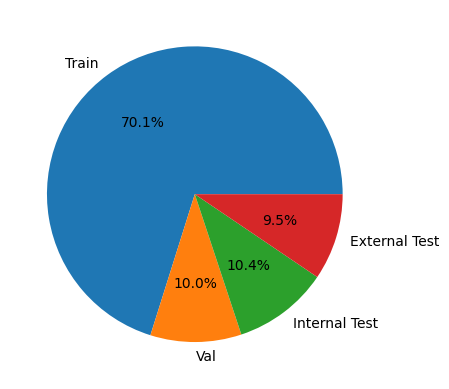

Train set count: 289
Val set count: 41
Interal Test set count: 43
External Test set count: 39


In [20]:
labels = ['Train', 'Val', 'Internal Test', 'External Test']
sizes = [len(train_set), len(val_set), len(internal_test_set), len(institution_test_set)]

plt.pie(sizes, labels=labels, autopct = '%1.1f%%')
plt.show()

print(f'Train set count: {len(train_set)}')
print(f'Val set count: {len(val_set)}')
print(f'Interal Test set count: {len(internal_test_set)}')
print(f'External Test set count: {len(institution_test_set)}')

In [15]:
# Save sets
useable_pts.to_csv('../data/all_study_patients.csv', index=False)
train_set_pts.to_csv('../data/train_set.csv', index=False)
val_set_pts.to_csv('../data/val_set.csv', index=False)
institution_test_set_pts.to_csv('../data/external_test_set.csv', index=False)
internal_test_set_pts.to_csv('../data/internal_test_set.csv', index=False)

### Preprocess Image Data

In [9]:
useable_pts = list(useable_pts.values)

In [ ]:
import nibabel as nib
import numpy as np

# Taking a look at FA values for each 

# Finally verify that all the files we need are present
base_dir = Path('../ext_storage/mri_data/all/')

sequence_suffixes = ['DTI_eddy_FA_wm']
missing_subjects = []

# If any file is missing we cannot use the subject
for subject in useable_pts:
    for sequence in sequence_suffixes:
        img = nib.load(base_dir / f'{subject}/{subject}_{sequence}.nii.gz').get_fdata()

        img_nan = img.copy()
        img_nan[img_nan == 0] = np.nan
        print('{:.2f} - {:.2f}; {:.2f}/{:.2f}, {:.2f}. '.format(
            np.min(img), np.max(img), np.nanmedian(img_nan), np.nanmean(img_nan), np.nanstd(img_nan)))
        

# Mean/median around 0.10-0.18 with stddev around 0.5-0.7
# Output cleared for cleanliness

In [5]:
from preprocess import preprocess_image_data

# All sequences
# ['T1_wm', 'T2_wm', 'DTI_eddy_MD_wm', 'DTI_eddy_trace_wm', 'DTI_eddy_FA_wm']

data_dir = '../ext_storage/mri_data/all/'
base_save_dir = '../ext_storage/mri_data/preprocessed'

check_shape = (181, 217, 181)
reshape_shape = (96, 112, 96)
dir_suffix = '' # No suffix since this is standard processing

# T1 and T2 have the same method
sequence_suffixes = ['T1_wm', 'T2_wm']
preprocess_methods = ['N4BC', 'tight_crop', 'intensity_norm', 'z_score', 'reshape']

preprocess_image_data(
    data_dir,
    sequence_suffixes,
    base_save_dir,
    useable_pts,
    preprocess_methods = preprocess_methods,
    dir_suffix = dir_suffix,
    reshape_shape = reshape_shape,
    check_shape = check_shape
)

# ADC from DTI needs a range and no N4BC
sequence_suffixes = ['DTI_eddy_MD_wm']
preprocess_methods = ['tight_crop', 'range_scale', 'reshape']
range_scale_params = (0, 3000e-6)

preprocess_image_data(
    data_dir,
    sequence_suffixes,
    base_save_dir,
    useable_pts,
    preprocess_methods = preprocess_methods,
    range_scale_params = range_scale_params,
    dir_suffix = dir_suffix,
    reshape_shape = reshape_shape,
    check_shape = check_shape
)


  3%|▎         | 26/828 [11:58<5:19:24, 23.90s/it]/opt/conda/lib/python3.10/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (96, 113, 96) != target shape (96, 112, 96). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
100%|██████████| 414/414 [05:35<00:00,  1.23it/s]


In [9]:

# Trace from DTI needs no N4BC
sequence_suffixes = ['DTI_eddy_trace_wm']
preprocess_methods = ['tight_crop', 'intensity_norm', 'z_score', 'reshape']

preprocess_image_data(
    data_dir,
    sequence_suffixes,
    base_save_dir,
    useable_pts,
    preprocess_methods = preprocess_methods,
    dir_suffix = dir_suffix,
    reshape_shape = reshape_shape,
    check_shape = check_shape
)

# FA from DTI needs range and no N4BC
sequence_suffixes = ['DTI_eddy_FA_wm']
preprocess_methods = ['tight_crop', 'intensity_norm', 'z_score', 'reshape']
range_scale_params = (0, 0.6)

preprocess_image_data(
    data_dir,
    sequence_suffixes,
    base_save_dir,
    useable_pts,
    preprocess_methods = preprocess_methods,
    range_scale_params = range_scale_params,
    dir_suffix = dir_suffix,
    reshape_shape = reshape_shape,
    check_shape = check_shape
)

  3%|▎         | 13/412 [00:08<04:09,  1.60it/s]/opt/conda/lib/python3.10/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (96, 113, 96) != target shape (96, 112, 96). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
100%|██████████| 412/412 [05:49<00:00,  1.18it/s]


### Tabular Data

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [12]:
import nibabel as nib
from pathlib import Path
import numpy as np

data_dir = Path('../ext_storage/mri_data/all/')

total_brain_injury_list = []

for subject in outcomes_df['studyid']:
    try:
    
        img = nib.load(data_dir / f'{subject}/{subject}_ADC-mask.nii.gz').get_fdata()
        total_brain_injury_list.append(np.sum(img))

    except:

        total_brain_injury_list.append(np.nan)

outcomes_df['total_brain_injury_volume'] = total_brain_injury_list

In [14]:
outcome_train_subset = outcomes_df.loc[outcomes_df['studyid'].isin(train_set_pts)]
outcome_val_subset = outcomes_df.loc[outcomes_df['studyid'].isin(val_set_pts)]

In [15]:
# Normalize whole outcome_df based on train

features = ['inf_gestage', 'total_brain_injury_volume']

for feature in features:

    z_score_scaler = StandardScaler()
    z_score_scaler.fit(outcome_train_subset[[feature]])
    outcomes_df[[feature+'_zscore']] = z_score_scaler.transform(outcomes_df[[feature]])

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(outcome_train_subset[[feature]])
    outcomes_df[[feature+'_minmax']] = min_max_scaler.transform(outcomes_df[[feature]])

In [16]:
# Fill NA with zero
# There's a bunch of with brain injury, but median is 0

print(outcomes_df['total_brain_injury_volume'].isna().sum())

outcomes_df['total_brain_injury_volume'] = outcomes_df['total_brain_injury_volume'].fillna(value=0)
outcomes_df['total_brain_injury_volume_zscore'] = outcomes_df['total_brain_injury_volume_zscore'].fillna(value=0)
outcomes_df['total_brain_injury_volume_minmax'] = outcomes_df['total_brain_injury_volume_minmax'].fillna(value=0)

84


In [17]:
outcomes_df.to_csv('../data/outcomes_updated.csv', index=False)